# Augmented VAE training

In [1]:
%load_ext autoreload
%autoreload 2

import os


os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.98"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config as get_pgm_config
from experiments.configs.vae_mnist import get_config as get_vae_config
from src.utils.input import get_data
from src.models.proto_gen_model import PrototypicalGenerativeModel, create_pgm_state, make_pgm_train_and_eval
from src.models.aug_vae import AUG_VAE, create_aug_vae_state, make_aug_vae_train_and_eval, make_aug_vae_plotting_fns
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1697141562.561736  259730 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
ANGLE = 180
pgm_config = get_pgm_config(f"{ANGLE}")
vae_config = get_vae_config(f"{ANGLE}")

In [3]:
rng = random.PRNGKey(pgm_config.seed)
data_rng, init_rng, state_rng = random.split(rng, 3)

## Get data

In [4]:
train_ds, val_ds, _ = get_data(pgm_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

In [5]:
# # get an example from the validation data 
# example = next(deterministic_data.start_input_pipeline(val_ds))['image'][0][14]

# plt.imshow(example, cmap='gray')
# plt.axis('off')
# plt.show()

# # now lets apply 4 random rotations to this image
# # and plot the results
# rotations = [50, 90, 110, 150, 180, 230, 300, 345, 1]
# for rot in rotations:
#     transformed = transform_image(example, jnp.array([0, 0, (rot - 90) * jnp.pi / 180, 0, 0]))
#     plt.imshow(rescale_for_imshow(transformed), cmap='gray')
#     plt.axis('off')
#     # save with same border as in plt.show
#     plt.savefig(f"rot_{rot}.png", bbox_inches='tight', pad_inches=0)
#     plt.show()

## Train PGM

In [6]:
pgm_model = PrototypicalGenerativeModel(**pgm_config.model.to_dict())

variables = pgm_model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+----------------------------------------------------+-------------+---------+-----------+--------+
| Name                                               | Shape       | Size    | Mean      | Std    |
+----------------------------------------------------+-------------+---------+-----------+--------+
| params/generative_net/Conditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_0/kernel | (256, 256)  | 65,536  | 9.69e-05  | 0.0627 |
| params/generative_net/Conditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | -0.000112 | 0.0624 |
| params/generative_net/Conditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/generative_net/Conditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       

In [7]:
params = flax.core.freeze(variables["params"])
del variables

pgm_state = create_pgm_state(params, state_rng, pgm_config)

train_step, eval_step = make_pgm_train_and_eval(pgm_model, pgm_config)

In [8]:
total_steps = pgm_config.gen_steps + pgm_config.inf_steps
final_pgm_state, history, _ = ciclo.train_loop(
    pgm_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        # ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * pgm_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

20000/20000 [==============================] - 613s 31ms/step - log_p_η_x_hat: 5.2497 - loss: -4.4870 - mae: 0.3674 - x_mse: 0.2019 - η_grad: 19.3430 - log_p_η_x_hat_test: 5.1649 - loss_test: -4.2582 - mae_test: 0.3904 - x_mse_test: 0.2050 - η_grad_test: 31.1198: 4:42 - log_p_η_x_hat: 4.8346 - loss: -4.3987 - mae: 0.6104 - x_mse: 0.2027 - η_grad: 48.4282 - log_p_η_x_hat_ - ETA: 4:33 - log_p_η_x_hat: 4.8566 - loss: -4.3597 - mae: 0.5461 - x_mse: 0.2022 - η_grad: 40.3701 - log_p_η_x_hat_test: 4.8574 - loss_test: -4.3835 - mae_test: 0.5540 - x_mse_test: 0.2031 - η_grad_test: 31. - ETA: 4:32 - log_p_η_x_hat: 4.8567 - loss: -4.3584 - mae: 0.5449 - x_mse: 0.2022 - η_grad: 40.0062 - log_p_η_x_hat - ETA: 4:03 - log_p_η_x_hat: 4.8959 - loss: -4.2877 - mae: 0.3824 - x_mse: 0.2023 - η_grad: 29.3850 - log_p_η_x_hat_test: 4.8194 - loss_test: -4.2030 - mae_tes - ETA: 3:57 - log_p_η_x_hat: 4.8601 - loss: -4.216 - ETA: 53s - log_p_η_x_hat: 5.2292 - loss: -4.4708 - mae: 0.3674 - x_mse: 0.2031 - η_grad:

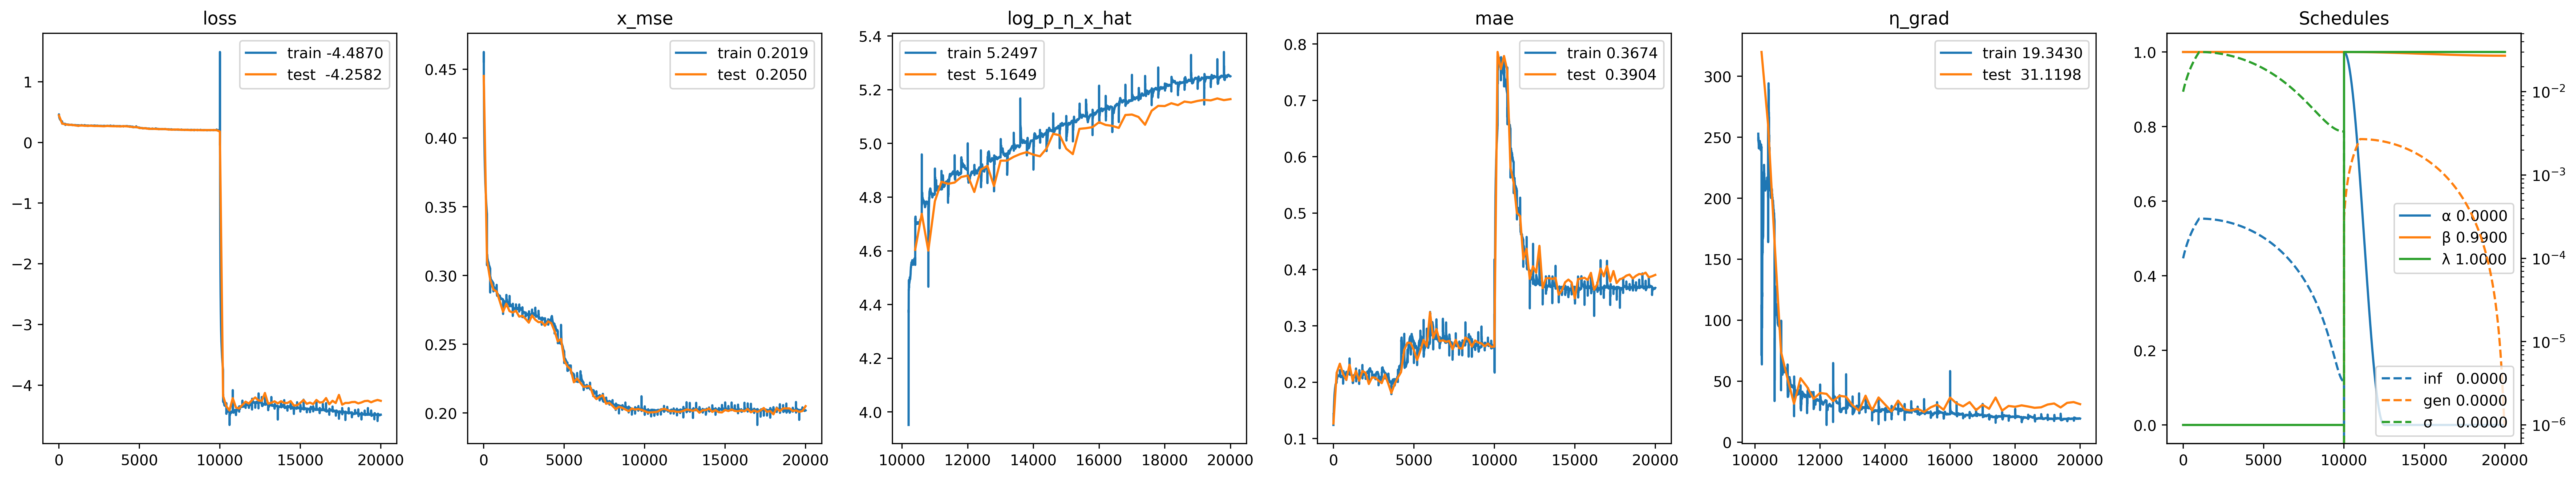

In [9]:
# plot the training history
steps, loss, x_mse, log_p_η_x_hat, mae, η_grad, λ, α, β, lr_inf, lr_gen, lr_σ, grad_norm = history.collect(
    "steps", "loss", "x_mse", "log_p_η_x_hat", "mae", "η_grad", "λ", "α", "β", "lr_inf", "lr_gen", "lr_σ", "grad_norm",
)
steps_test, loss_test, x_mse_test, log_p_η_x_hat_test, mae_test, η_grad_test = history.collect(
    "steps", "loss_test", "x_mse_test", "log_p_η_x_hat_test", "mae_test", "η_grad_test"
)

n_plots = 6
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[1].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("x_mse")


second_half = lambda x, b: x[len(x) // 2 + b:]

axs[2].plot(second_half(steps, 200), second_half(log_p_η_x_hat, 200), label=f"train {log_p_η_x_hat[-1]:.4f}")
axs[2].plot(second_half(steps_test, 2), second_half(log_p_η_x_hat_test, 2), label=f"test  {log_p_η_x_hat_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("log_p_η_x_hat")

axs[3].plot(steps, mae, label=f"train {mae[-1]:.4f}")
axs[3].plot(steps_test, mae_test, label=f"test  {mae_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("mae")

axs[4].plot(second_half(steps, 100), second_half(η_grad, 100), label=f"train {η_grad[-1]:.4f}")
axs[4].plot(second_half(steps_test, 1), second_half(η_grad_test, 1), label=f"test  {η_grad_test[-1]:.4f}")
axs[4].legend()
axs[4].set_title("η_grad")

axs[5].plot(steps, α, label=f"α {α[-1]:.4f}")
axs[5].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[5].plot(steps, λ, label=f"λ {λ[-1]:.4f}")
axs[5].legend()
axs[5].set_title("Schedules")

ax5_twin = axs[5].twinx()
ax5_twin.plot(steps, lr_inf, "--", label=f"inf   {lr_inf[-1]:.4f}")
ax5_twin.plot(steps, lr_gen, "--", label=f"gen {lr_gen[-1]:.4f}")
ax5_twin.plot(steps, lr_σ, "--", label=f"σ     {lr_σ[-1]:.4f}")
ax5_twin.legend(loc="lower right")
ax5_twin.set_yscale("log")

plt.show()

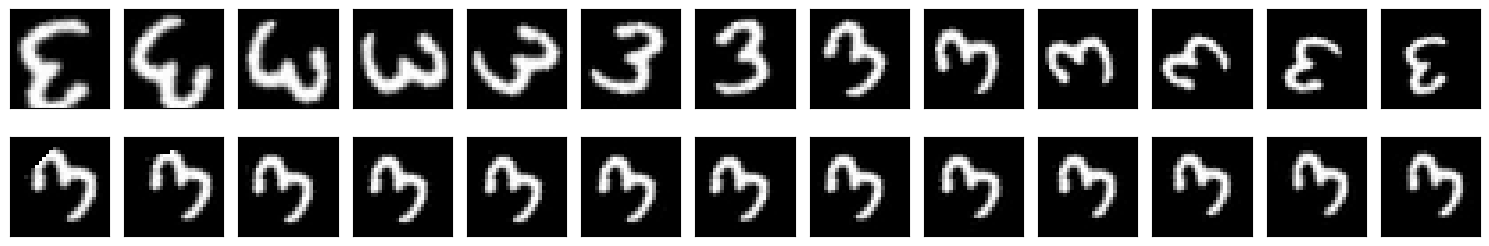

In [10]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η, _ = pgm_model.apply({"params": final_pgm_state.params},
                            x, train=False, rngs={"sample": rng})
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
        x_,
        jnp.linspace(-jnp.array(pgm_config.model.bounds) * mask, jnp.array(pgm_config.model.bounds) * mask, 13)
    )

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(rescale_for_imshow(x), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(rescale_for_imshow(xhat), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [11]:
from scipy.stats import gaussian_kde

p_H_X_hat, p_H_X_hat_vars = pgm_model.bind({"params": final_pgm_state.params}).generative_net.unbind()
q_H_X, q_H_X_vars = pgm_model.bind({"params": final_pgm_state.params}).inference_net.unbind()

# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    q_H_x = q_H_X.apply(q_H_X_vars, x)
    ηs_q, log_probs = q_H_x.sample_and_log_prob(seed=random.PRNGKey(0), sample_shape=(n))
    η = ηs_q[jnp.argmax(log_probs)]
    xhat = transform_image(x, -η)

    p_H_x_hat = p_H_X_hat.apply(p_H_X_hat_vars, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    D = p_H_x_hat.event_shape[0]
    fig, axs = plt.subplots(1, D + 2, figsize=(3*(D+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(pgm_config.model.bounds[i] - 1e-5, -pgm_config.model.bounds[i] + 1e-5, 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        ax2 = ax.twinx()
        ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        kde = gaussian_kde(ηs_q[:, i])
        ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        ax.set_xlim(-pgm_config.model.bounds[i], pgm_config.model.bounds[i])

    plt.tight_layout()
    plt.show()

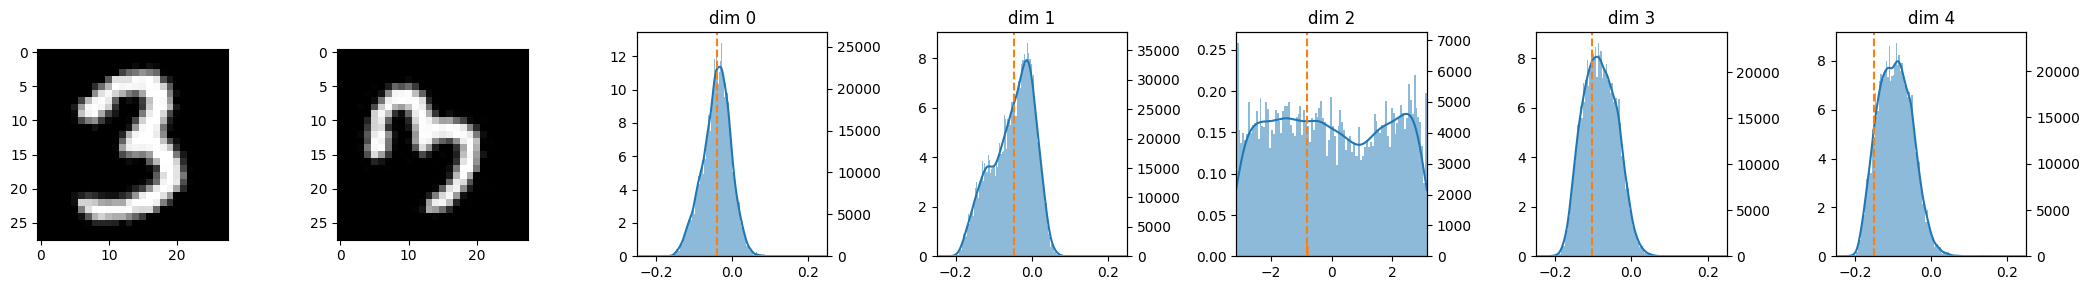

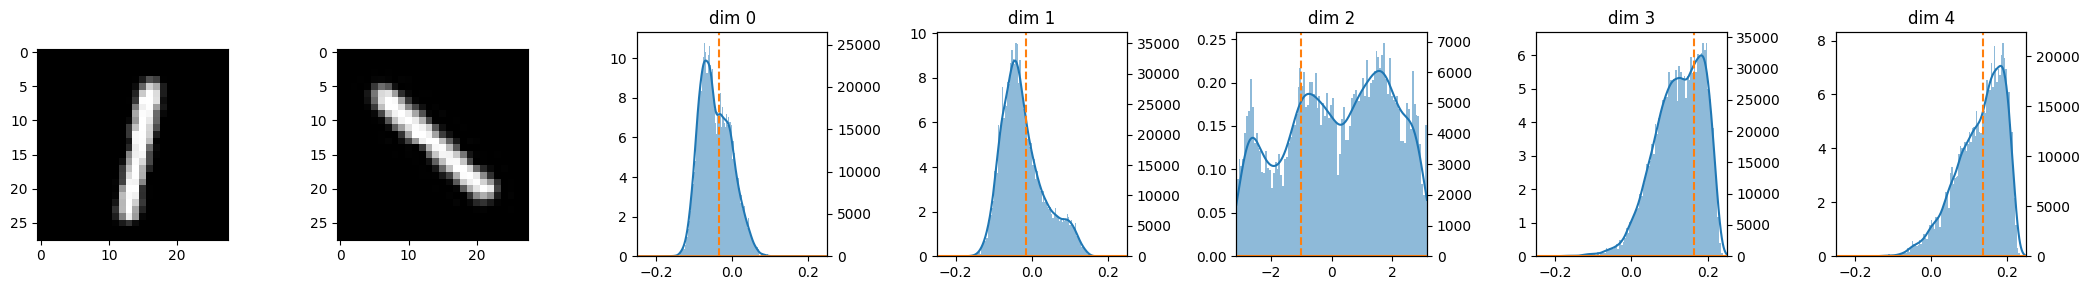

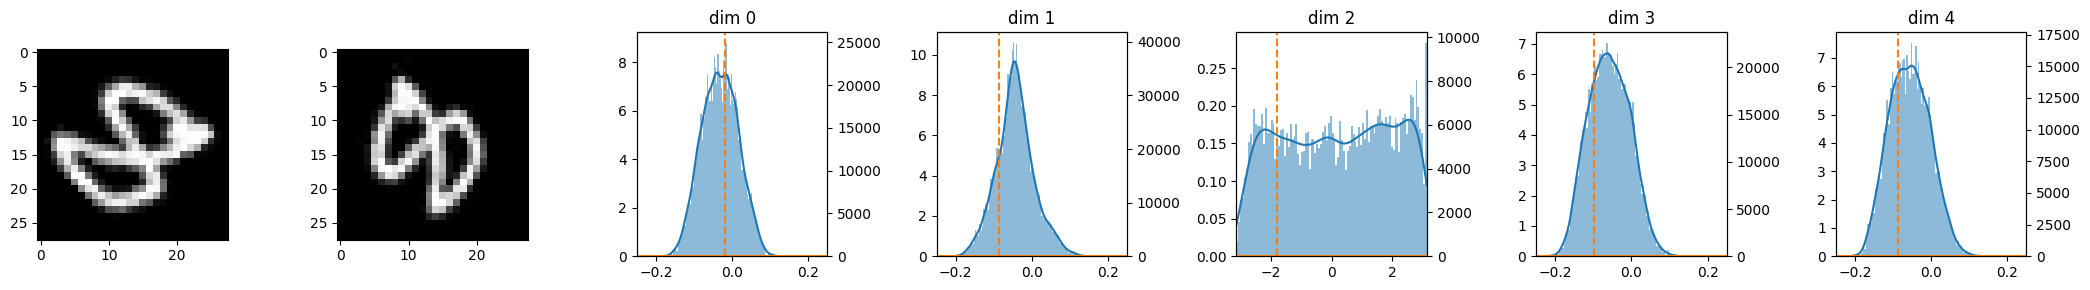

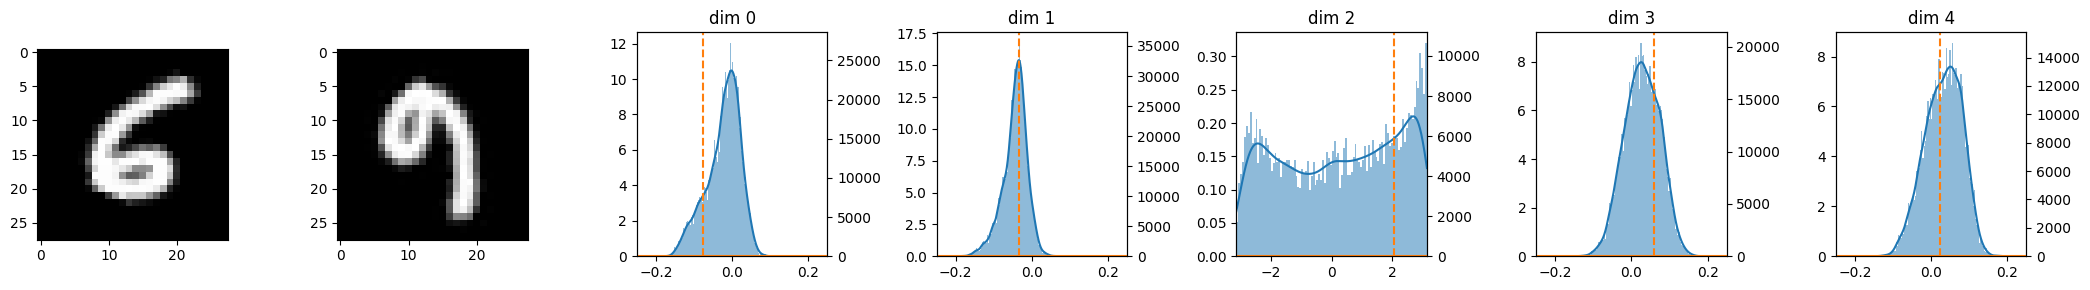

In [12]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

In [13]:
# save the final_pgm_state
checkpoints.save_checkpoint("pgm_model", final_pgm_state, final_pgm_state.step, overwrite=True)

INFO:absl:Saving checkpoint at step: 20001
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:OCDBT is initialized successfully.
INFO:absl:Saving item to pgm_model/checkpoint_20001.
INFO:absl:Specified `force`: removing existing directory.
INFO:absl:Renaming pgm_model/checkpoint_20001.orbax-checkpoint-tmp-1697142262506778 to pgm_model/checkpoint_20001
INFO:absl:Finished saving checkpoint to `pgm_model/checkpoint_20001`.


'pgm_model/checkpoint_20001'

## Train AUG-VAE

In [14]:
train_ds, val_ds, _ = get_data(vae_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

In [15]:
# load the final pgm state
final_pgm_state_loaded = checkpoints.restore_checkpoint("pgm_model", pgm_state)

INFO:absl:Restoring orbax checkpoint from pgm_model/checkpoint_20001
INFO:absl:Restoring item from pgm_model/checkpoint_20001.


INFO:absl:Finished restoring checkpoint from pgm_model/checkpoint_20001.


In [16]:
aug_vae_model = AUG_VAE(
    vae=vae_config.model.to_dict(),
    pgm=pgm_config.model.to_dict()
)

variables = aug_vae_model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=True)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+--------------------------------------------------------------------+------------------+---------+-----------+----------+
| Name                                                               | Shape            | Size    | Mean      | Std      |
+--------------------------------------------------------------------+------------------+---------+-----------+----------+
| params/proto_gen_model/generative_net/Conditioner_0/Dense_0/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/proto_gen_model/generative_net/Conditioner_0/Dense_0/kernel | (256, 256)       | 65,536  | -0.000136 | 0.0623   |
| params/proto_gen_model/generative_net/Conditioner_0/Dense_1/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/proto_gen_model/generative_net/Conditioner_0/Dense_1/kernel | (256, 256)       | 65,536  | -0.000138 | 0.0626   |
| params/proto_gen_model/generative_net/Conditioner_0/Dense_2/bias   | (65,)            | 65      | 0.0       | 0.0      |
| par

In [17]:
params = variables["params"]
params["proto_gen_model"] = final_pgm_state_loaded.params
params = flax.core.freeze(params)
del variables
del pgm_state
del final_pgm_state_loaded

aug_vae_state = create_aug_vae_state(params, state_rng, vae_config)

train_step, eval_step = make_aug_vae_train_and_eval(aug_vae_model, vae_config)
x = next(deterministic_data.start_input_pipeline(val_ds))['image'][0]
reconstruction_plot, sampling_plot = make_aug_vae_plotting_fns(vae_config, aug_vae_model, x)

2023-10-12 21:24:42.334589: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
parameter_overview.log_parameter_overview(params)

INFO:absl:
+-------------------------------------------------------------+------------------+---------+-----------+----------+
| Name                                                        | Shape            | Size    | Mean      | Std      |
+-------------------------------------------------------------+------------------+---------+-----------+----------+
| proto_gen_model/generative_net/Conditioner_0/Dense_0/bias   | (256,)           | 256     | -0.0953   | 0.138    |
| proto_gen_model/generative_net/Conditioner_0/Dense_0/kernel | (256, 256)       | 65,536  | -0.0136   | 0.0935   |
| proto_gen_model/generative_net/Conditioner_0/Dense_1/bias   | (256,)           | 256     | -0.0817   | 0.0967   |
| proto_gen_model/generative_net/Conditioner_0/Dense_1/kernel | (256, 256)       | 65,536  | -0.0265   | 0.083    |
| proto_gen_model/generative_net/Conditioner_0/Dense_2/bias   | (65,)            | 65      | -0.0988   | 0.519    |
| proto_gen_model/generative_net/Conditioner_0/Dense_2/kernel

    0/10000 [..............................] - ETA: 0s - elbo: -1130.1685 - iwlb: nan - ll: -1130.1685 - loss: 1130.1685 - z_kld: 0.0000e+00 - elbo_test: -953.7488 - iwlb_test: -938.1179 - ll_test: -953.6337 - loss_test: 953.7488 - z_kld_test: 0.0116

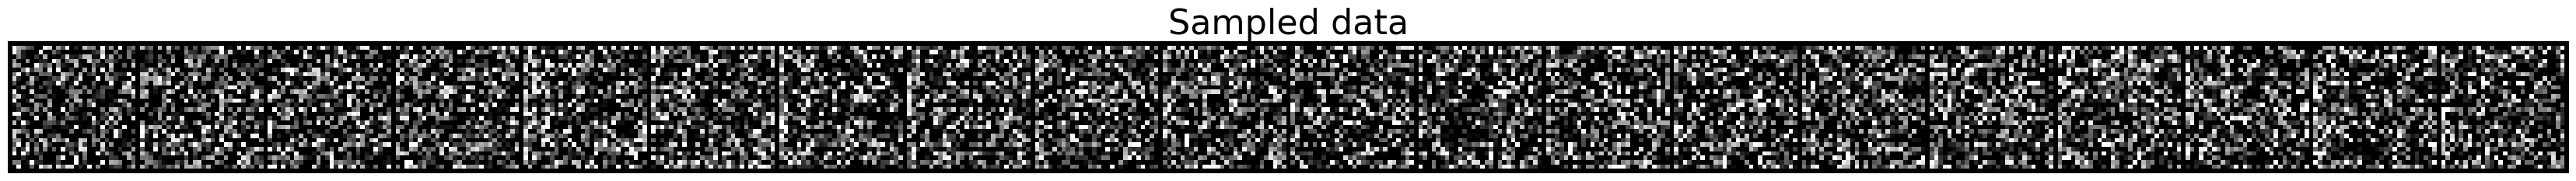

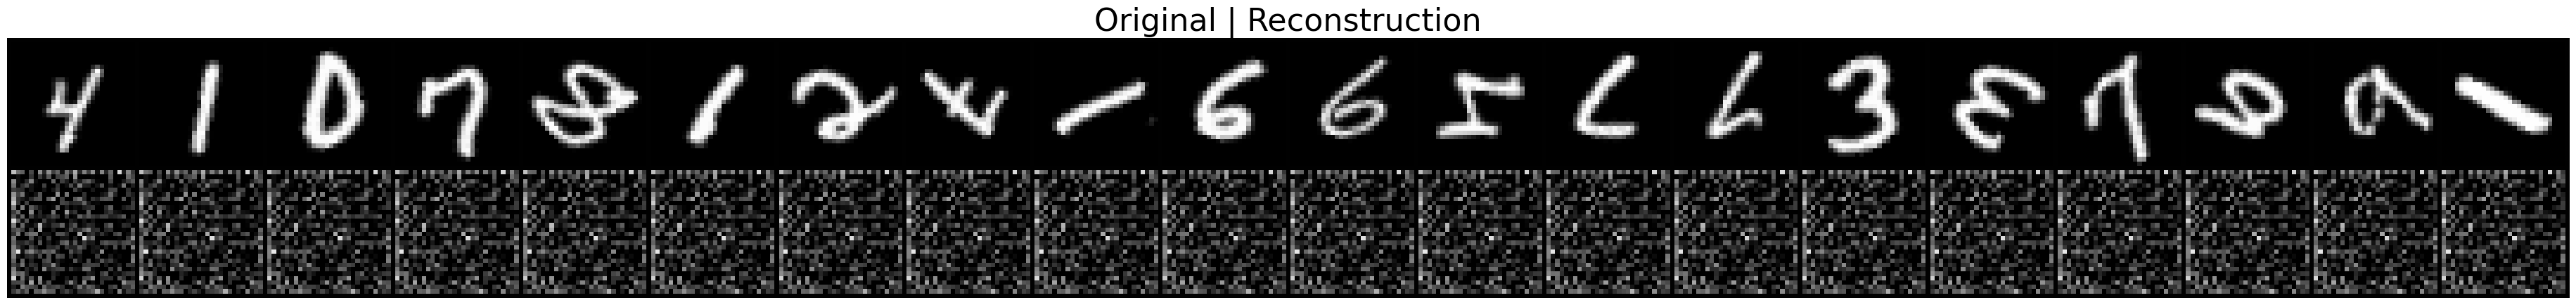

 1000/10000 [==>...........................] - ETA: 36:32 - elbo: -621.8265 - iwlb: nan - ll: -621.8108 - loss: 621.8265 - z_kld: 0.0016 - elbo_test: -607.7898 - iwlb_test: -607.1214 - ll_test: -607.7706 - loss_test: 607.7898 - z_kld_test: 0.0020        0454:36 - elbo: -834.8079 - iwlb: nan - ll: -834.7189 - loss: 834.8079 - z_kld: 0.0089 - elbo_test: -953.7488 - iwlb_test: -938.1179 - ll_test: -953.6337 - loss_test: 953.7488 - z_kld_test: 0.01 - ETA: 1:51:41 - elbo: -834.1515 - iwlb: nan - ll: -834.0647 - loss: 834.1515 - z_kld: 0.0087 - elbo_test: -953.7488 - iwlb_test: -938.1179 - ll_test: -953.6337 - loss_test: 953.7488 - z_kld_test: 0.01 - ETA: 1:48:56 - elbo: -833.5488 - iwlb: nan - ll: -833.4642 - loss: 833.5488 - z_kld: 0.0084 - elbo_test: -953.7488 - iwlb_test: -938.1179 - ll_test: -953.6337 - loss_test: 953.7488 - z_kld_test: 0.01 - ETA: 1:46:19 - elbo: -832.9262 - iwlb: nan - ll: -832.8436 - loss: 832.9262 - z_kld: 0.0082 - elbo_test: -953.7488 - iwlb_test: -938.1179 - ll_te

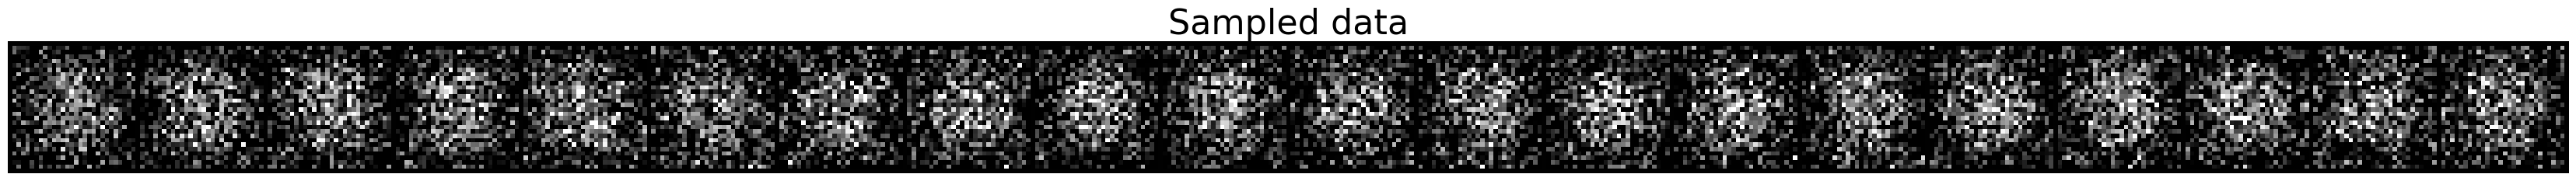

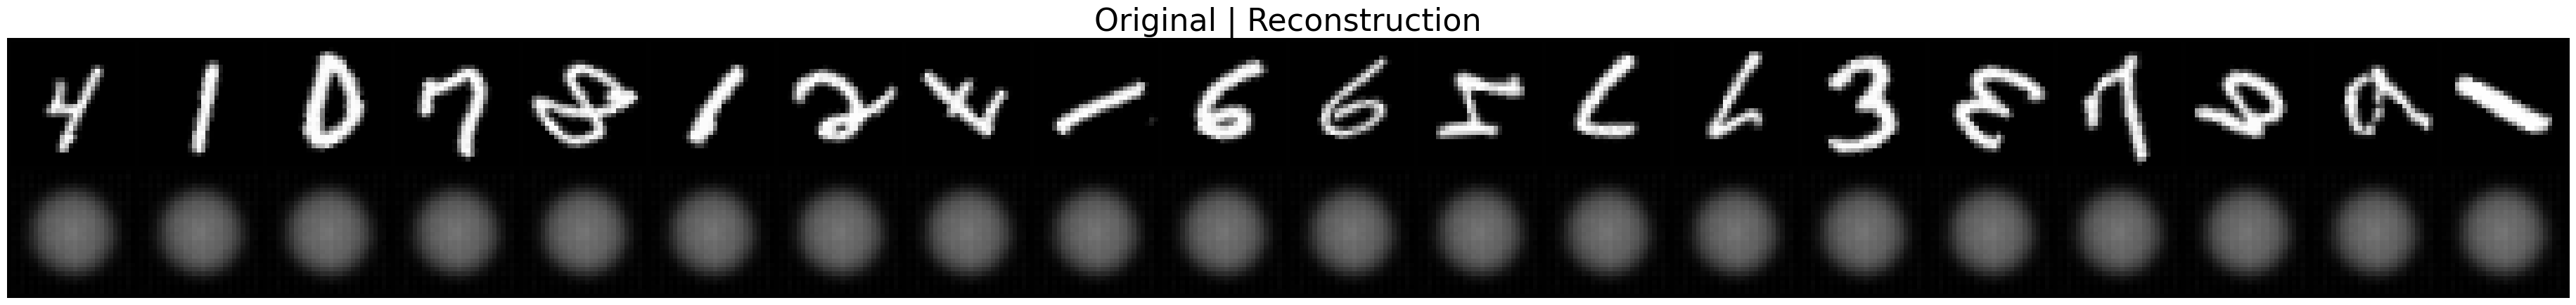

 2000/10000 [=====>........................] - ETA: 29:22 - elbo: -308.8141 - iwlb: nan - ll: -281.6529 - loss: 308.8141 - z_kld: 2.9594 - elbo_test: -296.3824 - iwlb_test: -230.5361 - ll_test: -256.0759 - loss_test: 296.3824 - z_kld_test: 4.4096    : 36:29 - elbo: -606.1902 - iwlb: nan - ll: -606.1737 - loss: 606.1902 - z_kld: 0.0017 - elbo_test: -607.7898 - iwlb_test: -607.1214 - ll_test: -607.7706 - loss_test: 607.7898 - z_kld_test: 0.00 - ETA: 36:25 - elbo: -606.2028 - iwlb: nan - ll: -606.1880 - loss: 606.2028 - z_kld: 0.0015 - elbo_test: -607.7898 - iwlb_test: -607.1214 - ll_test: -607.7706 - loss_test: 607.7898 - z_kld_test: 0. - ETA: 36:16 - elbo: -605.4675 - iwlb: nan - ll: -605.4546 - loss: 605.4675 - z_kld: 0.0013 - elbo_test: -607.7898 - iwlb_test: -607.1214 - ll_test: -607.7706 - loss_test: 607.7898 - z_kld_test: 0.00 - ETA: 36:12 - elbo: -605.1624 - iwlb: nan - ll: -605.1501 - loss: 605.1624 - z_kld: 0.0012 - elbo_test: -607.7898 - iwlb_test: -607.1214 - ll_test: -607.770

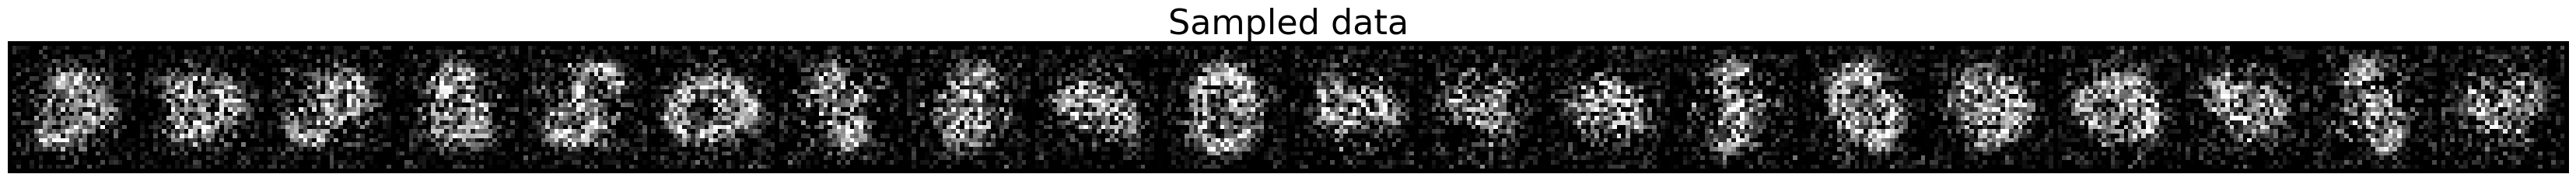

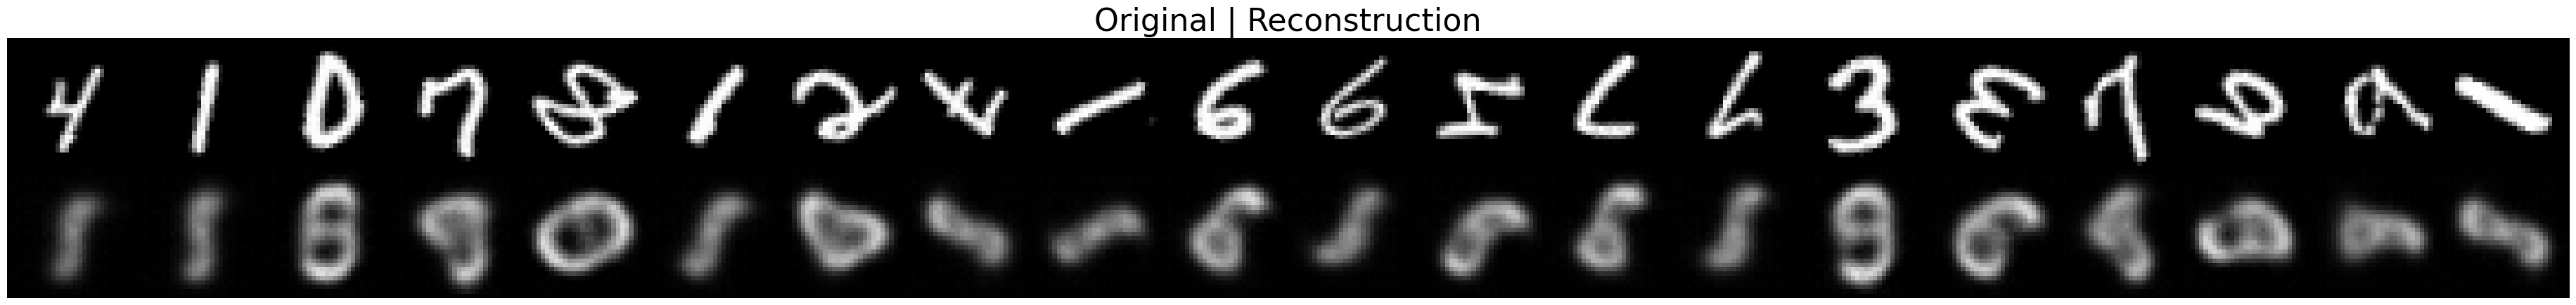

 3000/10000 [========>.....................] - ETA: 24:47 - elbo: 102.8470 - iwlb: nan - ll: 245.9816 - loss: -102.8470 - z_kld: 17.4514 - elbo_test: -68.6661 - iwlb_test: 205.7233 - ll_test: 95.0127 - loss_test: 68.6661 - z_kld_test: 20.0955     ETA: 28:25 - elbo: -272.8430 - iwlb: nan - ll: -230.3379 - loss: 272.8430 - z_kld: 4.6668 - elbo_test: -296.3824 - iwlb_test: -230.5361 - ll_test: -256.0759 - loss_test: 296.3824 - z_kld_test: 4.40 - ETA: 28:23 - elbo: -272.3199 - iwlb: nan - ll: -229.7112 - loss: 272.3199 - z_kld: 4.6787 - elbo_test: -296.3824 - iwlb_test: -230.5361 - ll_test: -256.0759 - loss_test: 296.3824 - z_kld_test: 4.40 - ETA: 28:21 - elbo: -271.8654 - iwlb: nan - ll: -229.0708 - loss: 271.8654 - z_kld: 4.6996 - elbo_test: -296.3824 - iwlb_test: -230.5361 - ll_test: -256.0759 - loss_test: 296.3824 - z_kld_test: 4.40 - ETA: 28:19 - elbo: -271.5292 - iwlb: nan - ll: -228.5625 - loss: 271.5292 - z_kld: 4.7189 - elbo_test: -296.3824 - iwlb_test: -230.5361 - ll_test: -256.0

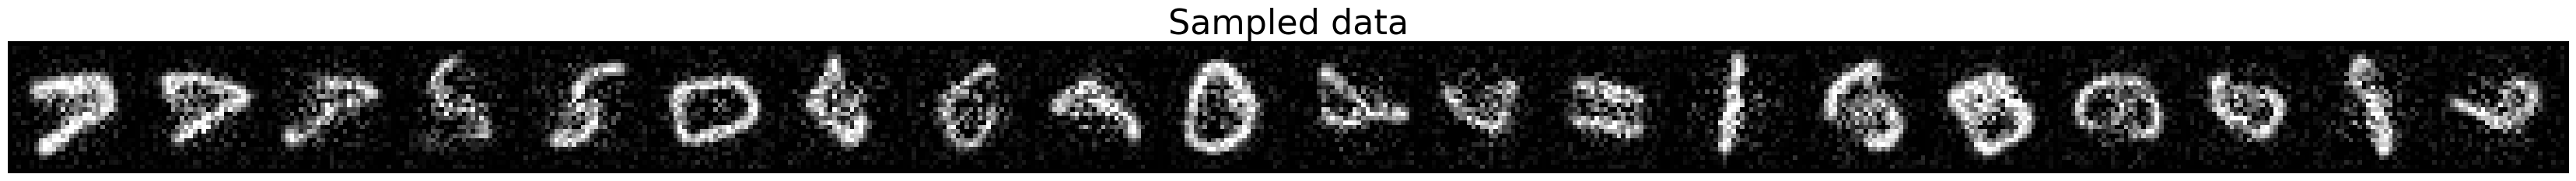

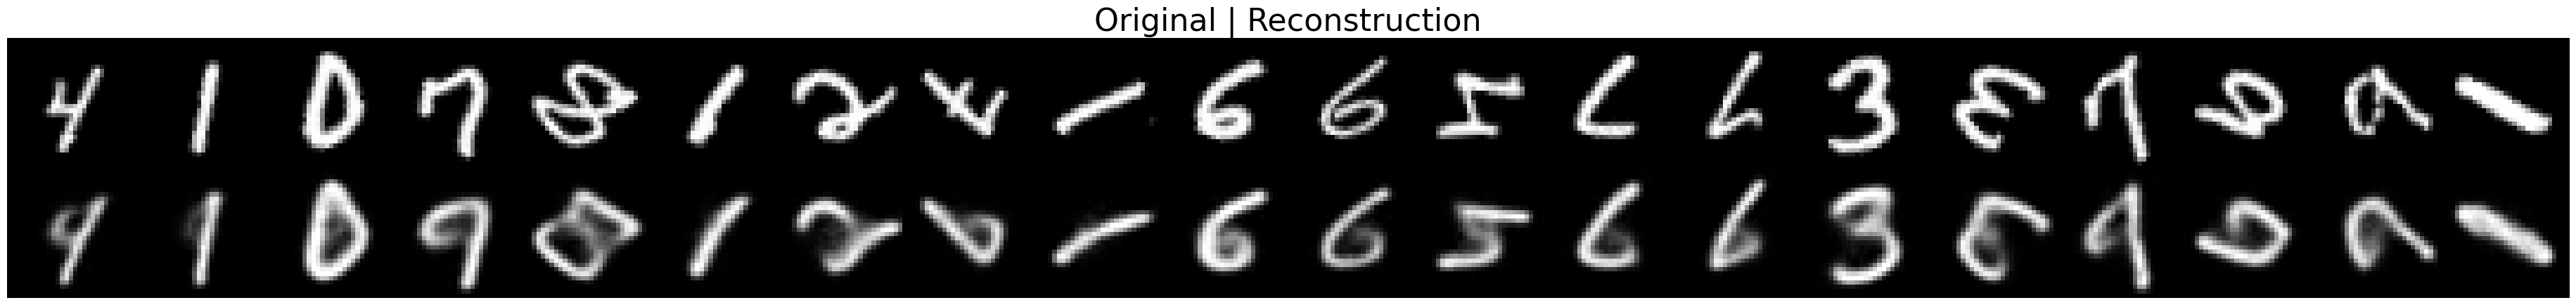

 4000/10000 [===========>..................] - ETA: 20:51 - elbo: 399.6517 - iwlb: nan - ll: 562.1003 - loss: -399.6517 - z_kld: 23.3471 - elbo_test: -86.4426 - iwlb_test: 278.8469 - ll_test: 95.0436 - loss_test: 86.4426 - z_kld_test: 26.3383 ETA: 24:29 - elbo: 128.5838 - iwlb: nan - ll: 275.3347 - loss: -128.5838 - z_kld: 18.0658 - elbo_test: -68.6661 - iwlb_test: 205.7233 - ll_test: 95.0127 - loss_test: 68.6661 - z_kld_test: 20.09 - ETA: 24:28 - elbo: 129.0483 - iwlb: nan - ll: 275.7939 - loss: -129.0483 - z_kld: 18.0677 - elbo_test: -68.6661 - iwlb_test: 205.7233 - ll_test: 95.0127 - loss_test: 68.6661 - z_kld_test: 20.09 - ETA: 24:26 - elbo: 128.9331 - iwlb: nan - ll: 275.7680 - loss: -128.9331 - z_kld: 18.0813 - elbo_test: -68.6661 - iwlb_test: 205.7233 - ll_test: 95.0127 - loss_test: 68.6661 - z_kld_test: 20.09 - ETA: 24:25 - elbo: 129.5826 - iwlb: nan - ll: 276.3778 - loss: -129.5826 - z_kld: 18.0789 - elbo_test: -68.6661 - iwlb_test: 205.7233 - ll_test: 95.0127 - loss_test: 68.

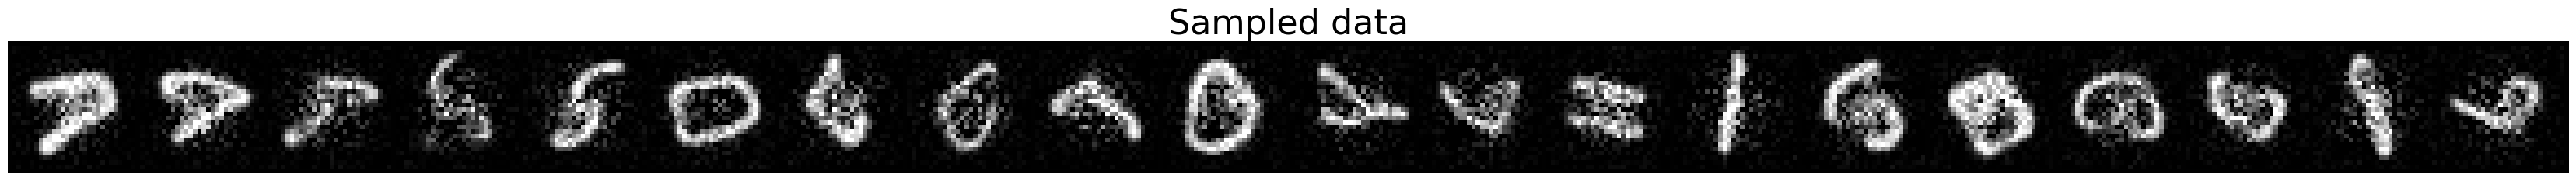

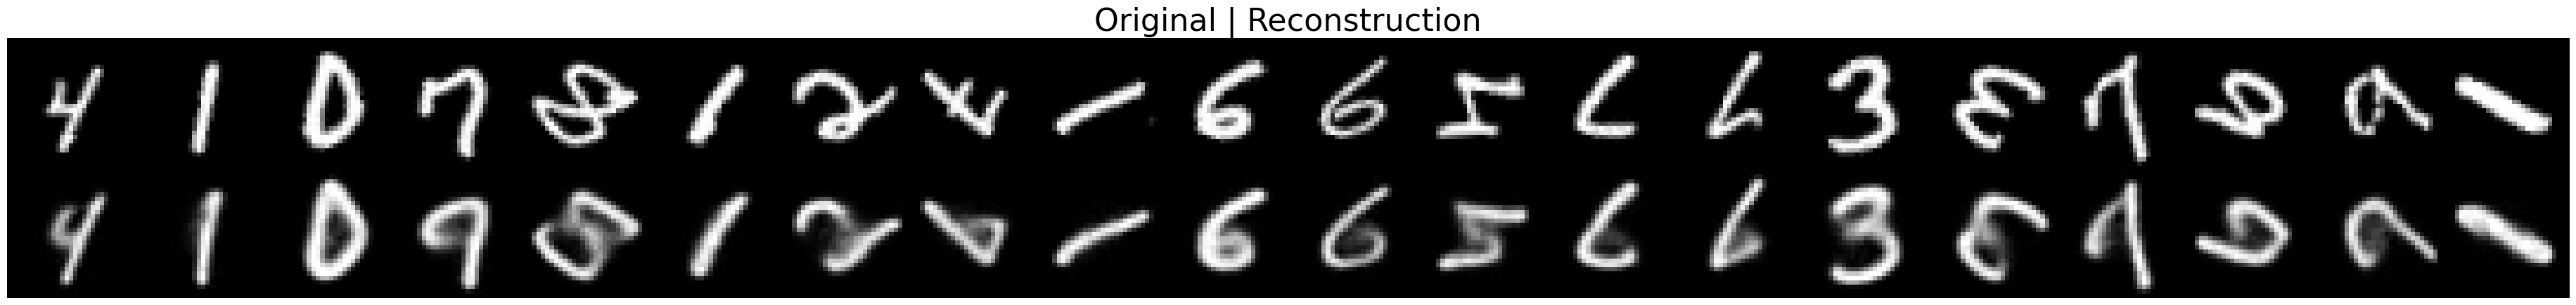

 5000/10000 [==============>...............] - ETA: 17:10 - elbo: 615.9196 - iwlb: nan - ll: 770.7690 - loss: -615.9196 - z_kld: 27.7946 - elbo_test: -283.8872 - iwlb_test: 109.2468 - ll_test: -111.8013 - loss_test: 283.8872 - z_kld_test: 31.2883: 20:12 - elbo: 424.6855 - iwlb: nan - ll: 587.3593 - loss: -424.6855 - z_kld: 23.8210 - elbo_test: -86.4426 - iwlb_test: 278.8469 - ll_test: 95.0436 - loss_test: 86.4426 - z_kld_test: 2 - ETA: 20:10 - elbo: 425.4459 - iwlb: nan - ll: 588.0030 - loss: -425.4459 - z_kld: 23.8180 - elbo_test: -86.4426 - iwlb_test: 278.8469 - ll_test: 95.0436 - loss_test: 86.4426 - z_kld_test: - ETA: 20:28 - elbo: 447.6959 - iwlb: nan - ll: 609.6210 - loss: -447.6959 - z_kld: 23.9816 - elbo_test: -89.7519 - iwlb_test: 276.7953 - ll_test: 92.1736 - loss_test: 89.7519 - z_kld_test: 2 - ETA: 20:25 - elbo: 442.2997 - iwlb: nan - ll: 605.3591 - loss: -442.2997 - z_kld: 24.1643 - elbo_test: -89.7519 - iwlb_test: 276.7953 - ll_test: 92.1736 - loss_test: 89.7519 - z_kld_t

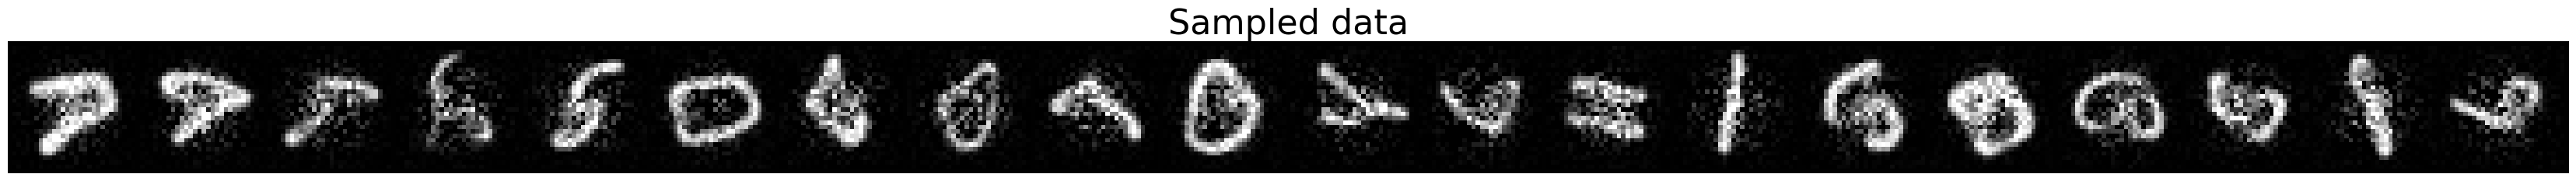

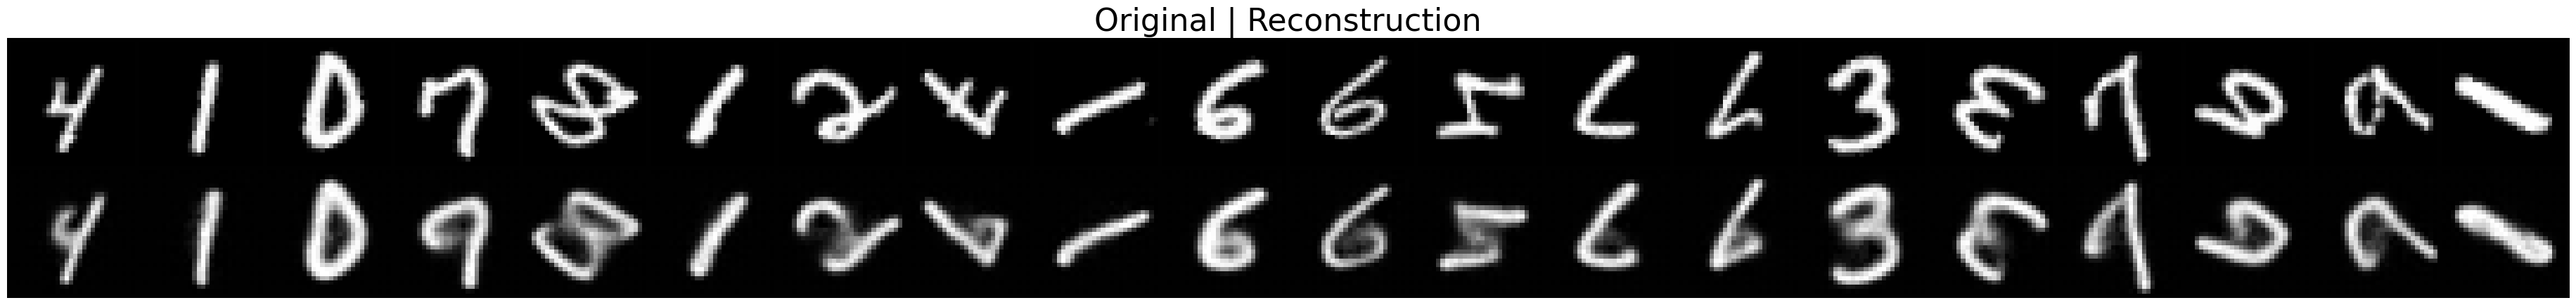

 6000/10000 [=================>............] - ETA: 13:38 - elbo: 777.2274 - iwlb: nan - ll: 911.4595 - loss: -777.2274 - z_kld: 32.1330 - elbo_test: -746.6733 - iwlb_test: -299.3316 - ll_test: -597.9422 - loss_test: 746.6733 - z_kld_test: 36.1927ETA: 16:18 - elbo: 651.1899 - iwlb: nan - ll: 802.4550 - loss: -651.1899 - z_kld: 28.5680 - elbo_test: -349.9611 - iwlb_test: 67.1595 - ll_test: -179.2099 - loss_test: 349.9611 - z_kld_test: 31.864 - ETA: 16:17 - elbo: 651.4883 - iwlb: nan - ll: 802.6973 - loss: -651.4883 - z_kld: 28.5650 - elbo_test: -349.9611 - iwlb_test: 67.1595 - ll_test: -179.2099 - loss_test: 349.9611 - z_kld_test: 31.864 - ETA: 16:17 - elbo: 651.7816 - iwlb: nan - ll: 802.9793 - loss: -651.7816 - z_kld: 28.5705 - elbo_test: -349.9611 - iwlb_test: 67.1595 - ll_test: -179.2099 - loss_test: 349.9611 - z_kld_test: 31.864 - ETA: 16:16 - elbo: 651.7753 - iwlb: nan - ll: 802.9666 - loss: -651.7753 - z_kld: 28.5770 - elbo_test: -349.9611 - iwlb_test: 67.1595 - ll_test: -179.209

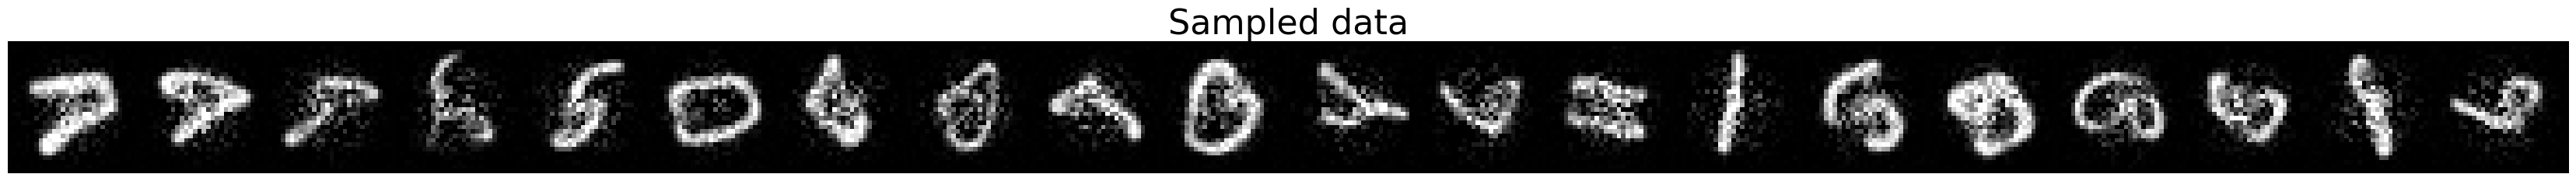

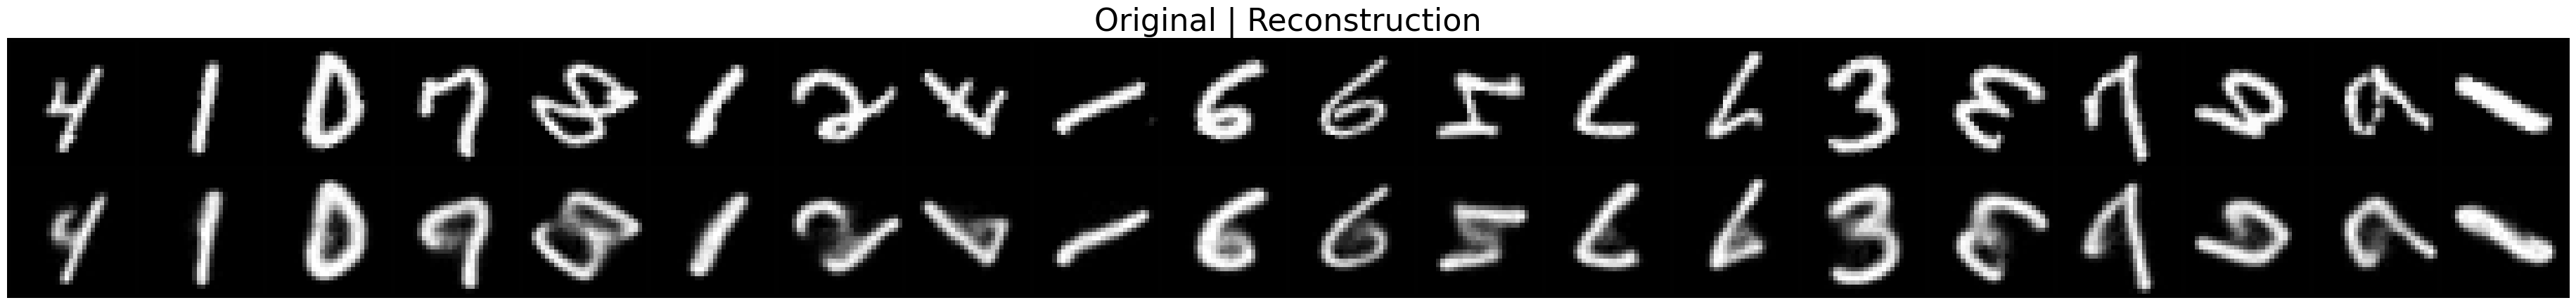

 7000/10000 [====================>.........] - ETA: 10:10 - elbo: 895.8757 - iwlb: nan - ll: 1001.6946 - loss: -895.8757 - z_kld: 36.3263 - elbo_test: -1276.0148 - iwlb_test: -860.0485 - ll_test: -1158.8347 - loss_test: 1276.0148 - z_kld_test: 41.0442A: 13:33 - elbo: 772.9015 - iwlb: nan - ll: 905.3676 - loss: -772.9015 - z_kld: 32.3353 - elbo_test: -746.6733 - iwlb_test: -299.3316 - ll_test: -597.9422 - loss_test: 746.6733 - z_kld_test: 36.192 - ETA: 13:33 - elbo: 774.0032 - iwlb: nan - ll: 906.6096 - loss: -774.0032 - z_kld: 32.3803 - elbo_test: -746.6733 - iwlb_test: -299.3316 - ll_test: -597.9422 - loss_test: 746.6733 - z_kld_test: 36.192 - ETA: 13:32 - elbo: 775.3638 - iwlb: nan - ll: 907.9977 - loss: -775.3638 - z_kld: 32.3977 - elbo_test: -746.6733 - iwlb_test: -299.3316 - ll_test: -597.9422 - loss_test: 746.6733 - z_kld_test: 36.192 - ETA: 13:31 - elbo: 776.6061 - iwlb: nan - ll: 909.1492 - loss: -776.6061 - z_kld: 32.3860 - elbo_test: -746.6733 - iwlb_test: -299.3316 - ll_test

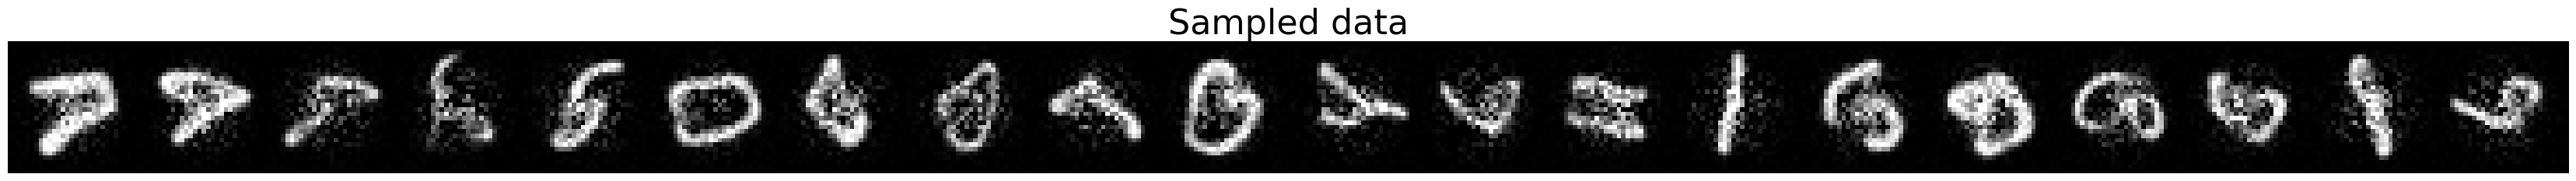

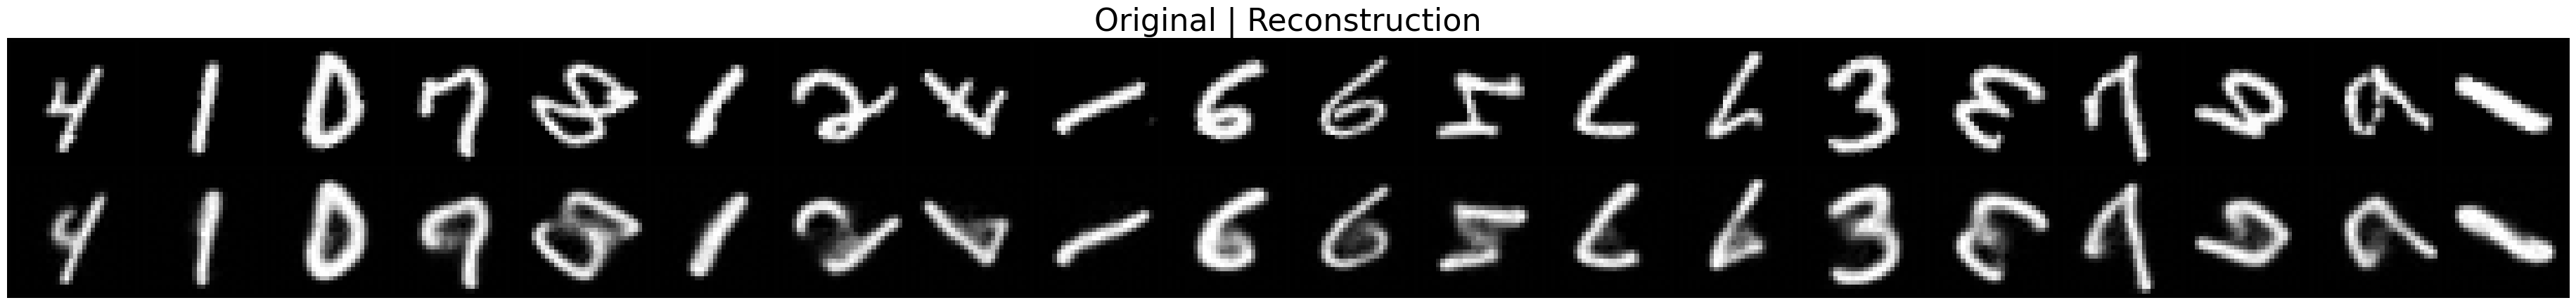

 8000/10000 [=======================>......] - ETA: 6:45 - elbo: 983.5549 - iwlb: nan - ll: 1061.2402 - loss: -983.5549 - z_kld: 40.8460 - elbo_test: -1612.0375 - iwlb_test: -1274.4730 - ll_test: -1526.4484 - loss_test: 1612.0375 - z_kld_test: 46.0299ETA: 9:48 - elbo: 907.7352 - iwlb: nan - ll: 1008.6310 - loss: -907.7352 - z_kld: 36.8354 - elbo_test: -1219.8120 - iwlb_test: -818.7330 - ll_test: -1106.4644 - loss_test: 1219.8120 - z_kld_test: 4 - ETA: 9:47 - elbo: 911.9845 - iwlb: nan - ll: 1013.2299 - loss: -911.9845 - z_kld: 37.0083 - elbo_test: -1219.8120 - iwlb_test: -818.7330 - ll_test: -1106.4644 - loss_test: 1219.8120 - z_kld_test: 41.33 - ETA: 9:46 - elbo: 913.2433 - iwlb: nan - ll: 1014.4201 - loss: -913.2433 - z_kld: 36.9982 - elbo_test: -1219.8120 - iwlb_test: -818.7330 - ll_test: -1106.4644 - loss_test: 1219.8120 - z_kld_test: 41.33 - ETA: 9:46 - elbo: 915.7418 - iwlb: nan - ll: 1016.8514 - loss: -915.7418 - z_kld: 36.9886 - elbo_test: -1219.8120 - iwlb_test: -818.7330 - ll

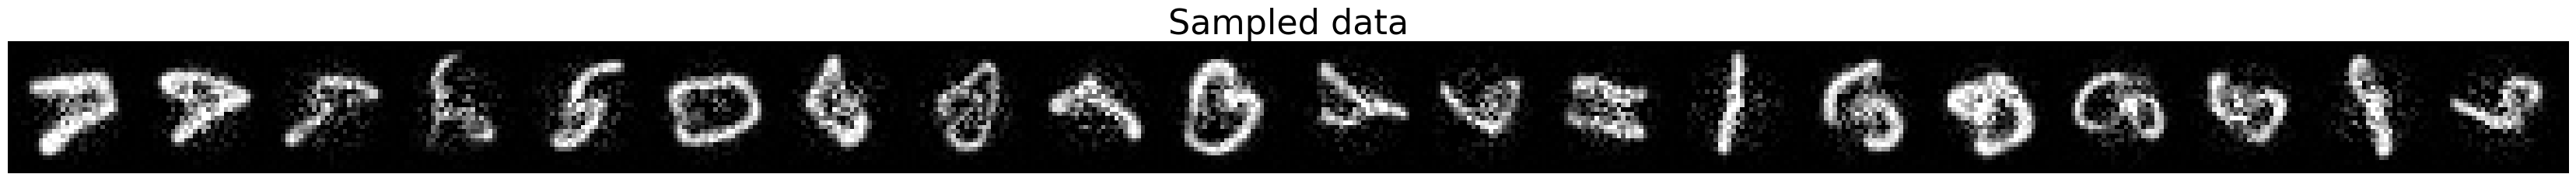

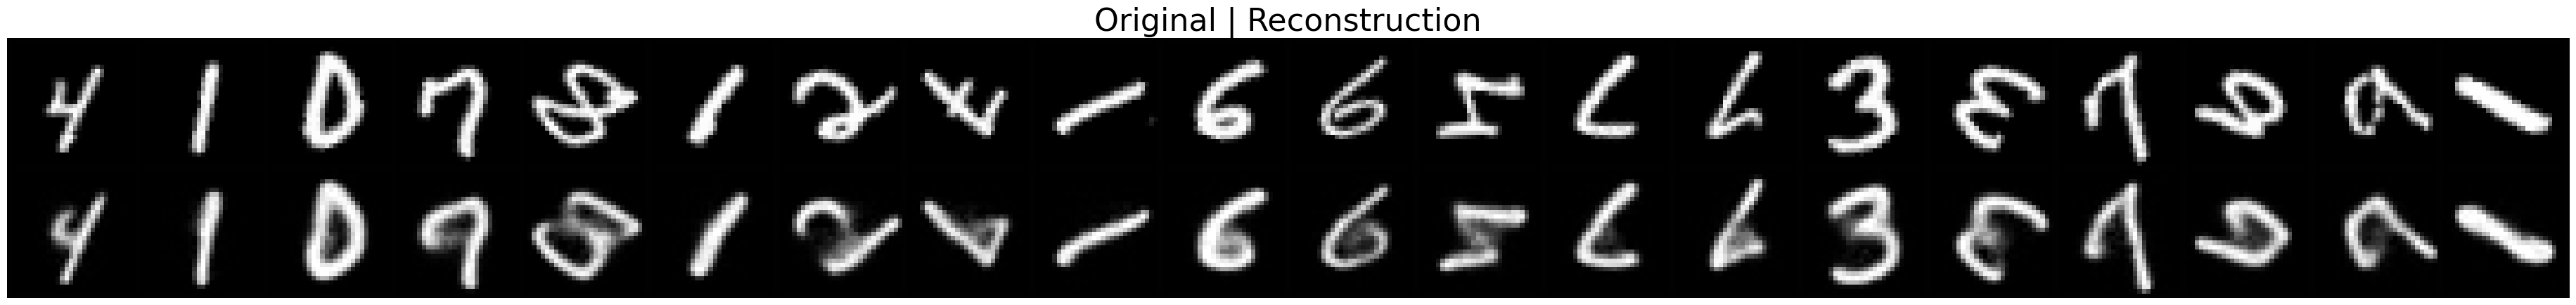

 9000/10000 [==========================>...] - ETA: 3:21 - elbo: -372.0140 - iwlb: nan - ll: -320.7422 - loss: 372.0140 - z_kld: 41.2484 - elbo_test: -25747.2227 - iwlb_test: -24446.5078 - ll_test: -25659.1504 - loss_test: 25747.2227 - z_kld_test: 72.1758   6:23 - elbo: 987.8975 - iwlb: nan - ll: 1062.1625 - loss: -987.8975 - z_kld: 41.8122 - elbo_test: -1549.2078 - iwlb_test: -1213.3784 - ll_test: -1466.7836 - loss_test: 1549.2078 - z_kld_test: 46.3 - ETA: 6:22 - elbo: 987.4875 - iwlb: nan - ll: 1061.5083 - loss: -987.4875 - z_kld: 41.7304 - elbo_test: -1549.2078 - iwlb_test: -1213.3784 - ll_test: -1466.7836 - loss_test: 1549.2078 - z_kld_test: 46.3 - ETA: 6:20 - elbo: 988.2820 - iwlb: nan - ll: 1062.2468 - loss: -988.2820 - z_kld: 41.7550 - elbo_test: -1549.2078 - iwlb_test: -1213.3784 - ll_test: -1466.7836 - loss_test: 1549.2078 - z_kld_test: 46.3 - ETA: 6:19 - elbo: 987.8500 - iwlb: nan - ll: 1061.7629 - loss: -987.8500 - z_kld: 41.7817 - elbo_test: -1549.2078 - iwlb_test: -1213.37

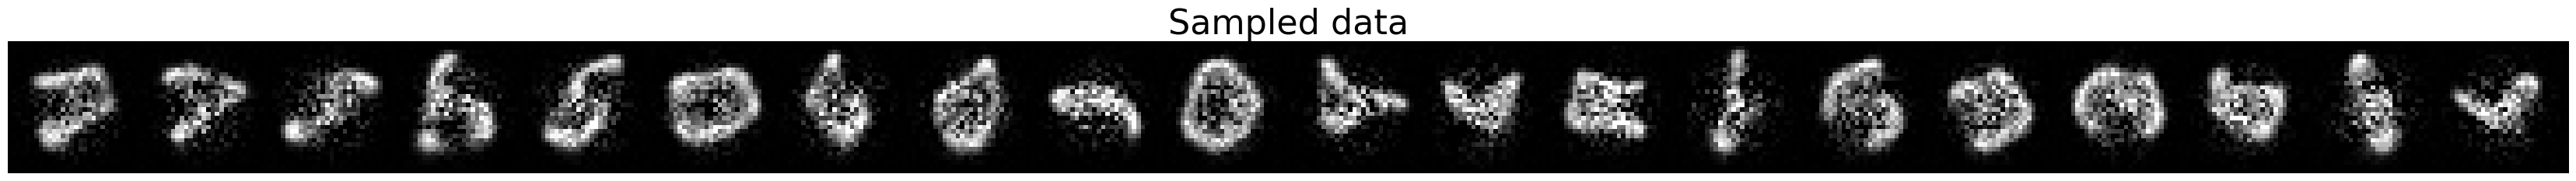

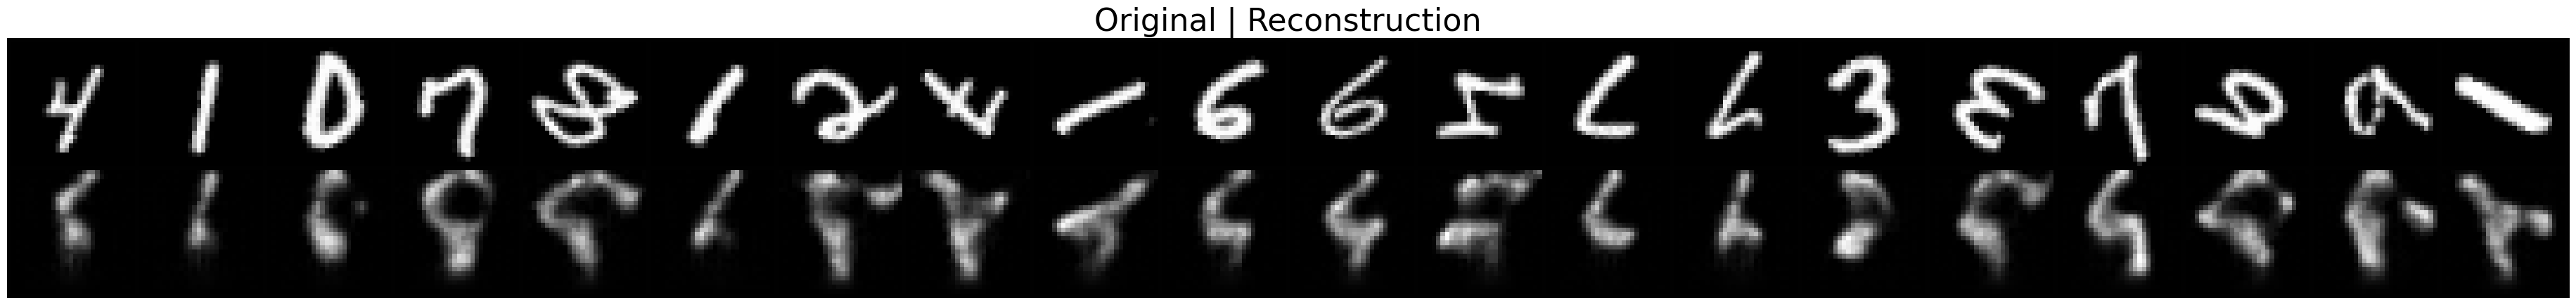

10000/10000 [==============================] - 2014s 201ms/step - elbo: 470.5546 - iwlb: nan - ll: 515.4885 - loss: -470.5546 - z_kld: 44.9001 - elbo_test: -29387.0000 - iwlb_test: -28494.3496 - ll_test: -29279.6621 - loss_test: 29387.0000 - z_kld_test: 107.34893:18 - elbo: -200.8294 - iwlb: nan - ll: -149.8282 - loss: 200.8294 - z_kld: 41.9223 - elbo_test: -25747.2227 - iwlb_test: -24446.5078 - ll_t - ETA: 2:20 - elbo: 283.7397 - iwlb: nan - ll: 330.4438 - loss: -283.7397 - z_kld: 42.1668 - elbo_test: -25420.8867 - iwlb_test: -24392.3926 - ll_test: -25315.6191 - loss_test: 25420.8867 - z_kld_t - ETA: 2:17 - elbo: 297.0540 - iwlb: nan - ll: 344.0336 - loss: -297.0540 - z_kld: 42.4861 - elbo_test: -25420.8867 - iwlb_test: -24392.3926 - ll_test: -25315.6191 - loss_test: 25420.8867 - z_kld_test: 94.98 - ETA: 2:17 - elbo: 305.2219 - iwlb: nan - ll: 352.2221 - loss: -305.2219 - z_kld: 42.5164 - elbo_test: -25420.8867 - iwlb_test: -24392.3926 - ll_test: -25315.6191 - loss_test: 25420.8867 - 

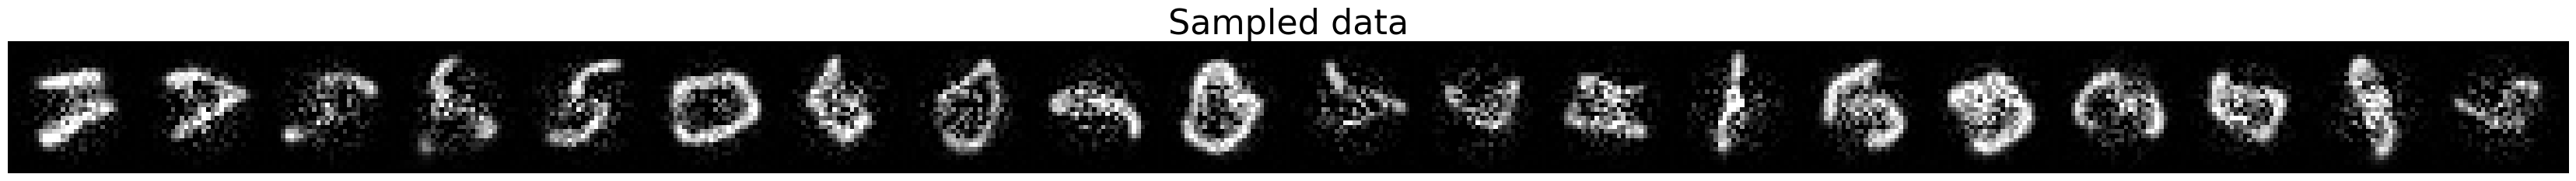

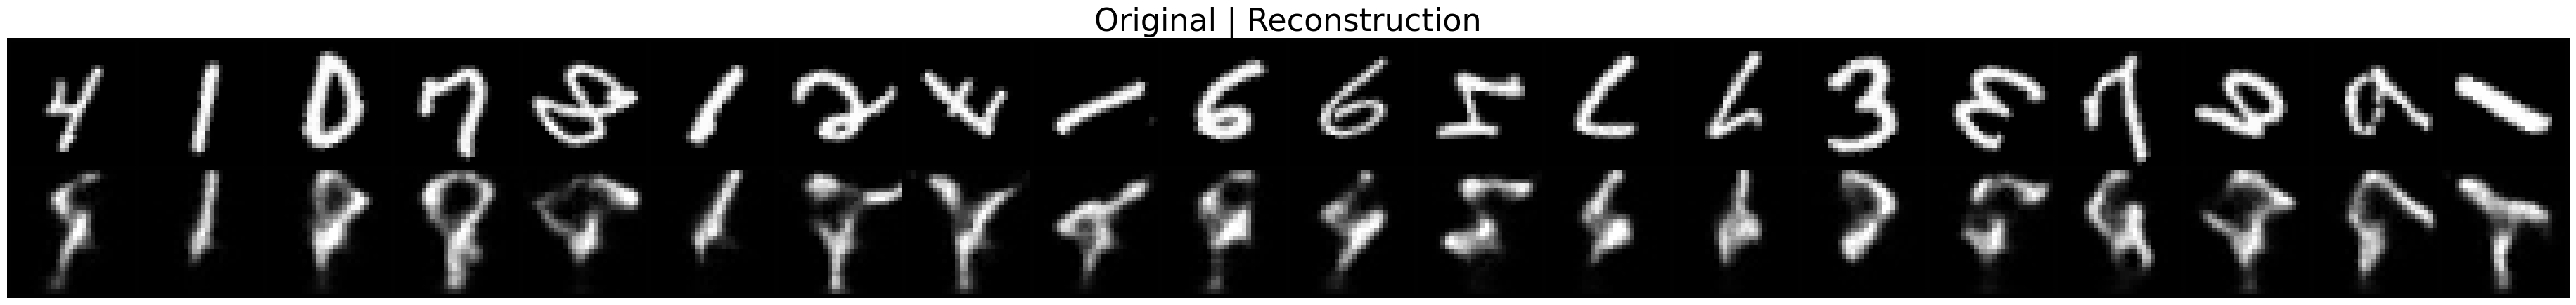

In [19]:
final_aug_vae_state, history, _ = ciclo.train_loop(
    aug_vae_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.every(int(vae_config.steps * vae_config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        # ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(vae_config.steps * vae_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=vae_config.steps),
    ],
    stop=vae_config.steps + 1,
)

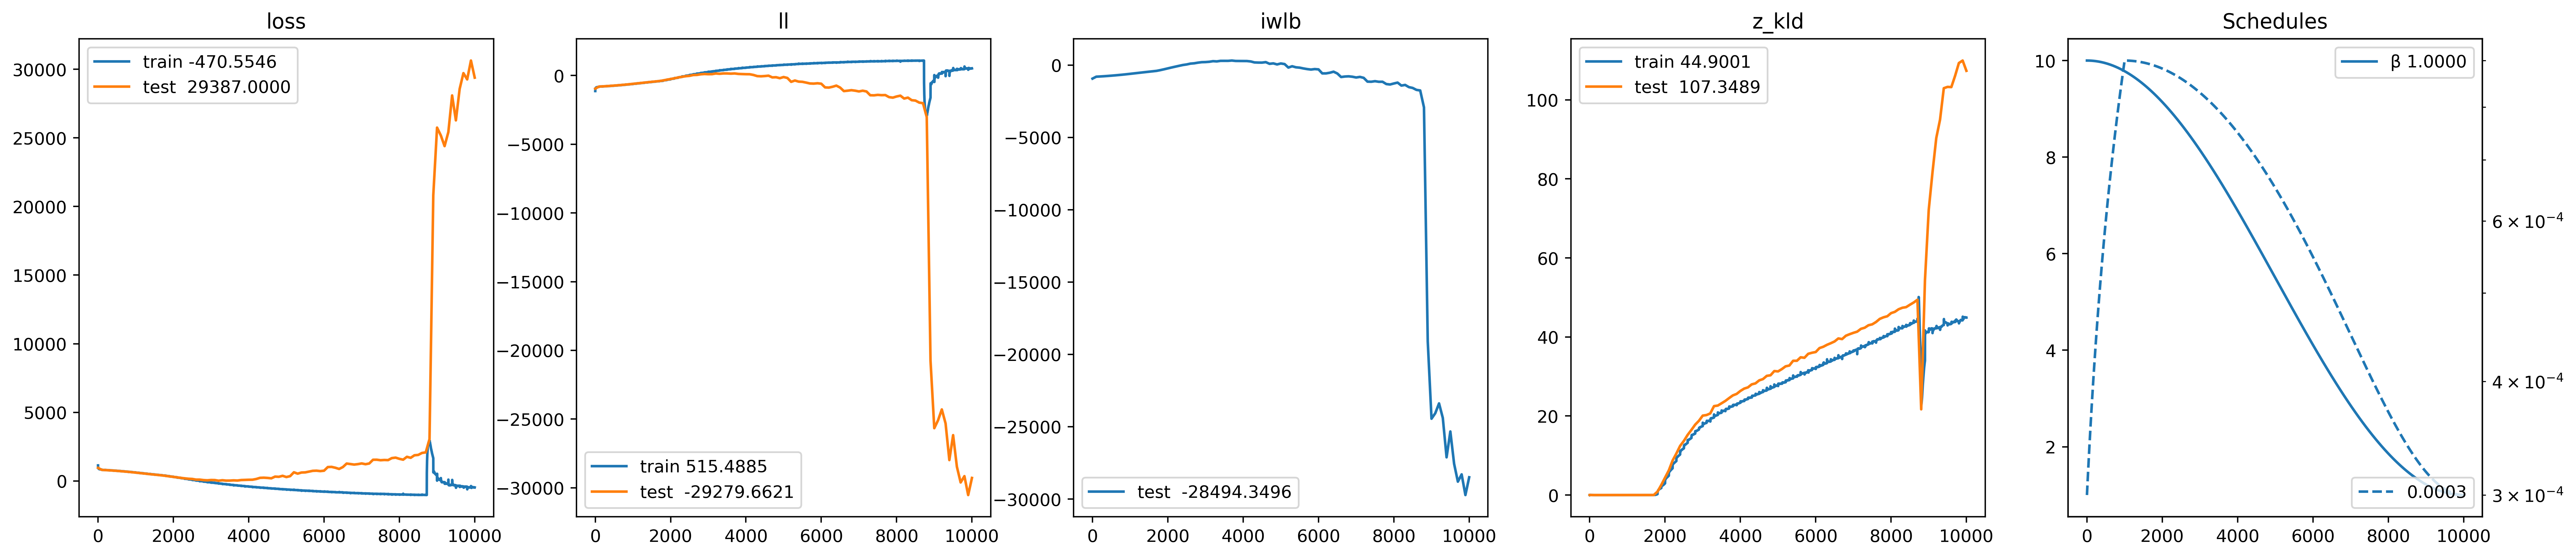

In [20]:
# plot the training history
steps, loss, elbo, ll, z_kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "z_kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, z_kld_test, iwlb_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "z_kld_test", "iwlb_test"
)

n_plots = 5
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps_test, iwlb_test, label=f"test  {iwlb_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, z_kld, label=f"train {z_kld[-1]:.4f}")
axs[3].plot(steps_test, z_kld_test, label=f"test  {z_kld_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("z_kld")

axs[4].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[4].legend()
axs[4].set_title("Schedules")

ax4_twin = axs[4].twinx()
ax4_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax4_twin.legend(loc="lower right")
ax4_twin.set_yscale("log")

plt.show()